This notebook shows various approaches we took to 
transform recorded images to match the size and
orientation of actual images.

In [2]:
"""Run notebook from project root"""

import os
if os.path.split(os.getcwd())[-1] == "notebooks":
    %cd ..
print(f"Running notebook from {os.getcwd()}")

/Users/kincannonwilson/Desktop/School/Projection-Correction
Running notebook from /Users/kincannonwilson/Desktop/School/Projection-Correction


/Users/kincannonwilson/Desktop/School/Projection-Correction/venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
"""imports"""

import cv2
import matplotlib.pyplot as plt
import numpy as np
from utils.read_img import pathToCV2
from utils.transform_recorded import manual_perspective_transform
from helpers import show_img_in_subplots, show_single_img
PLT_RGB = "viridis"

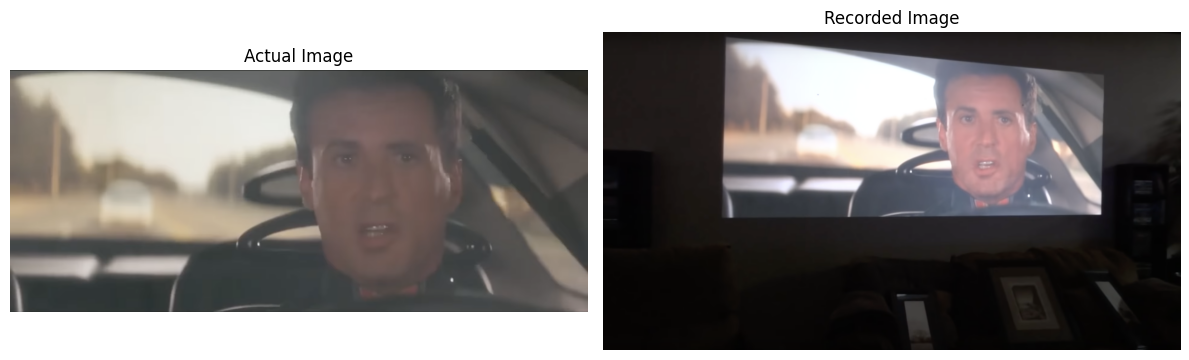

In [4]:
"""Start by showing example images"""

# Paths to example files
actual_example_path = os.path.join("inputs", "actual_example1.png")
recorded_example_path = os.path.join("inputs", "recorded_example1.png")

# Create OpenCV images
actual = pathToCV2(actual_example_path)
recorded = pathToCV2(recorded_example_path)

# Show example images
images = [actual, recorded]
titles = ["Actual Image", "Recorded Image"]
show_img_in_subplots(images, titles, 1, 2, (12,8))

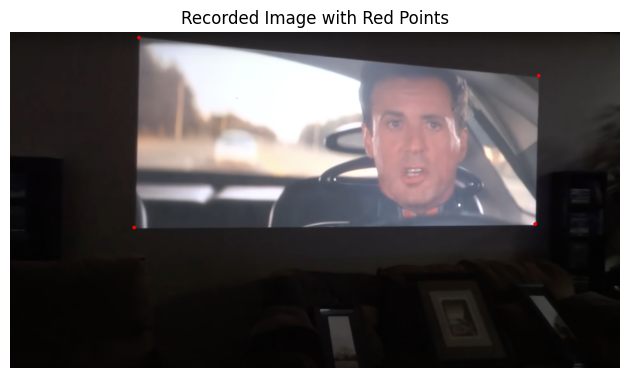

In [5]:
# Draw some red points on image to find projector bounds
points = [(730, 37), (2995, 252), (2975, 1090), (703, 1110)]

recorded_copy = recorded.copy()
for point in points:
    cv2.circle(recorded_copy, point, 5, (255, 0, 0), 10)

# Display the recorded image with red points
show_single_img(recorded_copy, "Recorded Image with Red Points")


recorded_transformed shape: (1444, 3456, 3)


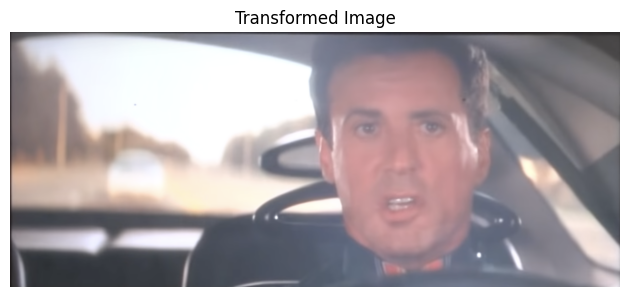

In [6]:
# First, let's manually crop out the desired region
src_pts = np.array(points, dtype=np.float32)
recorded_transformed = manual_perspective_transform(actual, recorded, src_pts)
print(f"recorded_transformed shape: {recorded_transformed.shape}")
show_single_img(recorded_transformed, "Transformed Image")

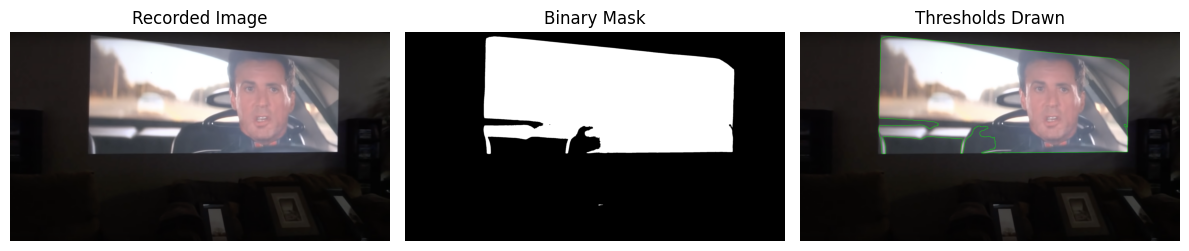

In [7]:
"""OpenCV's contours based on thresholding"""

# Pre-process the recorded image
gray_image = cv2.cvtColor(recorded, cv2.COLOR_RGB2GRAY)
_, binary_mask = cv2.threshold(gray_image, 80, 255, cv2.THRESH_BINARY)

# Draw contours onto copy of recorded image
contours_thresh, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour_thresh = sorted(contours_thresh, key=cv2.contourArea, reverse=True)[0]
thresh_contours_img = recorded.copy()
cv2.drawContours(thresh_contours_img, [largest_contour_thresh], -1, (0, 255, 0), 2)

# Show the result
images = [recorded, binary_mask, thresh_contours_img]
titles = ["Recorded Image", "Binary Mask", "Thresholds Drawn"]
cmaps = [PLT_RGB, "gray", PLT_RGB]
show_img_in_subplots(images, titles, 1, 3, (12,8), cmaps)

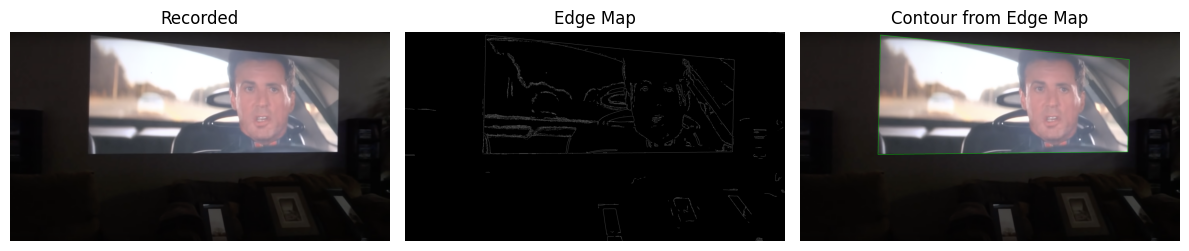

In [8]:
"""OpenCV's contours based on edge map"""

# Find edge map using Canny edge detection on slightly blurred image
blurred_gray = cv2.GaussianBlur(gray_image, (5, 5), 0)
edges = cv2.Canny(blurred_gray, 7, 21)

# Apply dilation to close gaps in between object edges
kernel_dilation = np.ones((11, 11), np.uint8)
dilated_edges = cv2.dilate(edges, kernel_dilation, iterations=1)

# Apply erosion to reduce noise and fine-tune object boundaries
kernel_erosion = np.ones((7, 7), np.uint8)
eroded_image = cv2.erode(dilated_edges, kernel_erosion, iterations=1)

# Find largest contour by area (should be screen)
contours_edge, _ = cv2.findContours(eroded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour_edge = sorted(contours_edge, key=cv2.contourArea, reverse=True)[0]

# Apply Douglas-Peucker algorithm to simplify the contour into a quadrilateral
epsilon = 0.02 * cv2.arcLength(largest_contour_edge, True)
approx_contour = cv2.approxPolyDP(largest_contour_edge, epsilon, True)

# Draw the found contour
edge_contours_img = recorded.copy()
cv2.drawContours(edge_contours_img, [approx_contour], -1, (0, 255, 0), 2)

# Plot the results
images = [recorded, edges, edge_contours_img]
cmaps = [PLT_RGB, "gray", PLT_RGB]
titles = ["Recorded", "Edge Map", "Contour from Edge Map"]
show_img_in_subplots(images, titles, 1, 3, (12,8), cmaps)

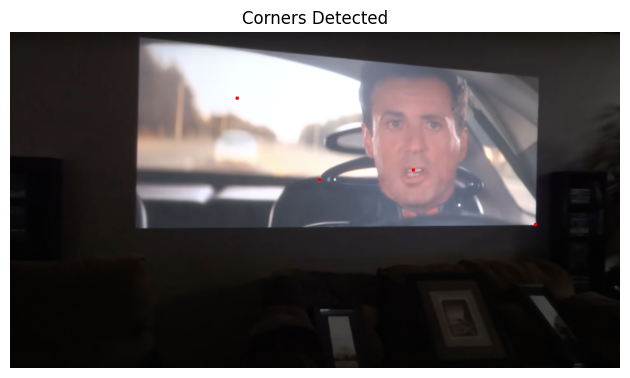

In [9]:
"""Corner detection"""

# Set the parameters for the Shi-Tomasi corner detector
max_corners = 4
quality_level = 0.01
min_distance = 500

# Detect corners
corners = cv2.goodFeaturesToTrack(gray_image, max_corners, quality_level, min_distance)

# Convert corners to integers
corners = np.intp(corners)

# Draw circles at the corner points
recorded_copy = recorded.copy()
for corner in corners:
    x, y = corner.ravel()
    cv2.circle(recorded_copy, (x, y), radius=10, color=(255, 0, 0), thickness=-1)

# Show the result
show_single_img(recorded_copy, "Corners Detected")

In [10]:
"""Attempt at using Hough Transform to detect a quadrilateral"""

raise Exception("This method takes too long to run!")

# Hough transform
lines = cv2.HoughLines(dilated_edges, 1, np.pi / 180, threshold=100)

# Convert lines to endpoints
endpoints = []
for line in lines:
    rho, theta = line[0]
    a, b = np.cos(theta), np.sin(theta)
    x0, y0 = a * rho, b * rho
    x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * (a))
    x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * (a))
    endpoints.append(((x1, y1), (x2, y2)))

# Find intersections of lines
intersections = []
for i in range(len(endpoints)):
    for j in range(i + 1, len(endpoints)):
        x1, y1 = endpoints[i][0]
        x2, y2 = endpoints[i][1]
        x3, y3 = endpoints[j][0]
        x4, y4 = endpoints[j][1]
        det = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
        if det != 0:
            intersection_x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / det
            intersection_y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / det
            intersections.append((int(intersection_x), int(intersection_y)))

# Filter intersections to find quadrilateral
quadrilateral = []
for i in range(len(intersections)):
    for j in range(i + 1, len(intersections)):
        for k in range(j + 1, len(intersections)):
            for l in range(k + 1, len(intersections)):
                quadrilateral = [intersections[i], intersections[j], intersections[k], intersections[l]]

# Draw the quadrilateral
image_with_quadrilateral = recorded.copy()
cv2.polylines(image_with_quadrilateral, [np.array(quadrilateral)], isClosed=True, color=(0, 0, 255), thickness=2)

# Display the result
plt.imshow(cv2.cvtColor(image_with_quadrilateral, cv2.COLOR_BGR2RGB))
plt.title("Quadrilateral Detected using Hough Transform")
plt.axis("off")
plt.show()

Exception: This method takes too long to run!

Looks like contour detection based on an edge map that's pre-processed
with dilation and erosion does the best job!

In [16]:
def crop_and_warp(template_path, image_path):
    # Read template and image containing the template
    template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Find keypoints and descriptors for both the template and the image
    kp_template, des_template = sift.detectAndCompute(template, None)
    kp_image, des_image = sift.detectAndCompute(image, None)

    # Initialize a Brute-Force Matcher
    bf = cv2.BFMatcher()

    # Match descriptors of the template and the image
    matches = bf.knnMatch(des_template, des_image, k=2)

    # Apply ratio test to find good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Draw matches
    matched_image = cv2.drawMatches(template, kp_template, image, kp_image, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Extract matched keypoints
    src_pts = np.float32([kp_template[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_image[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Find perspective transformation
    M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Warp the image
    warped_image = cv2.warpPerspective(image, np.linalg.inv(M), (template.shape[1], template.shape[0]))

    return warped_image, matched_image

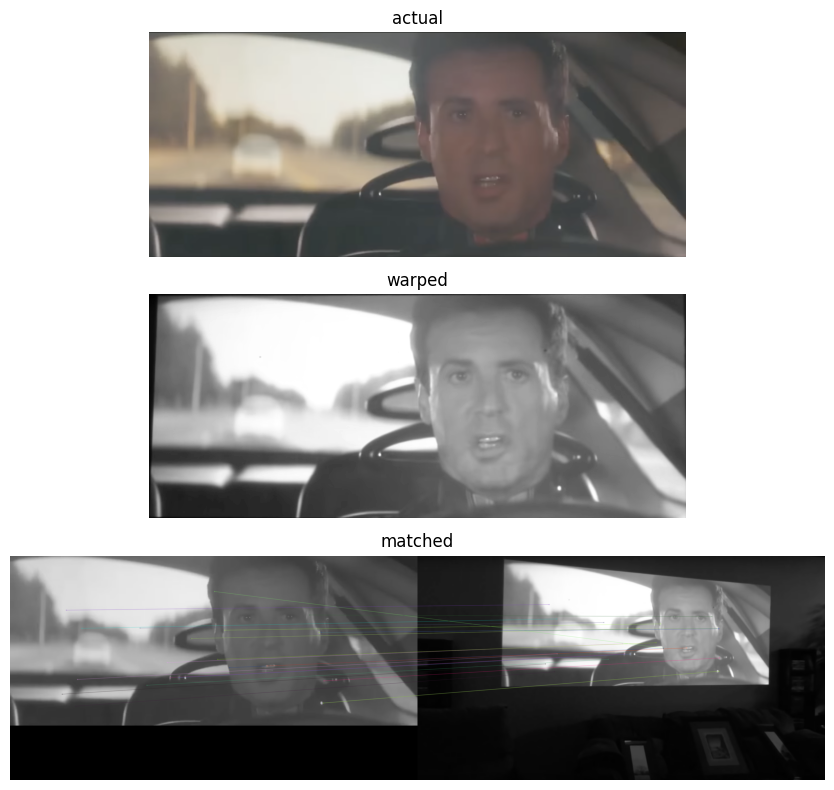

In [18]:
warped, matched = crop_and_warp("inputs/actual_example1.png", "inputs/recorded_example1.png")
show_img_in_subplots([actual, warped,matched], ["actual", "warped","matched"], 3, 1, (12,8), cmaps=["gray", "gray", "gray"])